In [61]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('../_data/DataSet_Hitelbiralat_joados.csv')

In [4]:
df.head()

,id_client,id_shop,sex,marital_status,age,quant_dependants,education,flag_residencial_phone,area_code_residencial_phone,payment_day,shop_rank,residence_type,months_in_residence,flag_mothers_name,flag_fathers_name,flag_residence_town_working_town,flag_residence_state_working_state,months_in_the_job,profession_code,mate_income,flag_residencial_address_postal_address,flag_other_card,quant_banking_accounts,personal_reference_1,personal_reference_2,flag_mobile_phone,flag_contact_phone,personal_net_income,cod_application_booth,quant_additional_cards_in_the_application,flag_card_insurance_option,target
0,1,22,F,O,44,0,NaN,N,31,12,0,P,12,Y,Y,N,Y,48,731,0.0,Y,N,0,VERA,LUCIA,N,N,300.0,0,0,N,1
1,2,15,F,S,18,0,NaN,Y,31,20,0,P,216,Y,Y,Y,Y,12,853,0.0,Y,N,0,SARA,FELIPE,N,N,300.0,0,0,N,1
2,3,24,F,C,22,0,NaN,Y,31,8,0,P,48,Y,N,Y,Y,12,40,0.0,Y,N,0,HELENA,DOMINGOS SOGRA,N,N,229.0,0,0,N,1
3,4,12,F,C,47,0,NaN,N,31,25,0,P,180,Y,Y,N,Y,24,35,0.0,Y,N,0,JACI,VALERIA ALEXANDRA TRAJANO,N,N,304.0,0,0,N,1
4,5,16,F,S,28,0,NaN,Y,31,25,0,O,12,Y,Y,Y,Y,12,24,0.0,Y,N,0,MARCIA CRISTINA ZANELLA,SANDRO L P MARTINS,N,N,250.0,0,0,N,1


In [52]:
df.shape

(50000, 32)

In [6]:
df['target'].value_counts()

1    40126
0     9874
Name: target, dtype: int64

In [54]:
np.random.seed(1)
df['pred_baseline'] = np.random.rand(df.shape[0])

In [56]:
df['pred_baseline_int'] = df['pred_baseline'].apply(lambda x: 
                                                   1 if x >=0.5 else 0)

In [58]:
df['pred_baseline_int'].value_counts()

1    25060
0    24940
Name: pred_baseline_int, dtype: int64

In [59]:
recall_score(df['target'], df['pred_baseline_int'])

0.502865972187609

In [63]:
roc_auc_score(df['target'], df['pred_baseline_int'])

0.5042180782550361

In [65]:
dummy_cols = ['sex', 'marital_status', 'residence_type']

In [81]:
dummy_names = []
for col in dummy_cols:
    dummy_df = pd.get_dummies(df[col], prefix=col, drop_first=True)
    dummy_names = dummy_names + dummy_df.columns.tolist()
    df = pd.concat([df, dummy_df], axis=1)

In [84]:
X_cols = ['age', 'months_in_residence', 'months_in_the_job', 
 'personal_net_income', 'mate_income']

In [85]:
X_cols = X_cols + dummy_names

In [89]:
X = df.loc[:, X_cols]
y = df['target']

In [88]:
model = LogisticRegression()

pred_proba = cross_val_predict(model, X, y, cv=4, method='predict_proba')
pred = cross_val_predict(model, X, y, cv=4)

In [95]:
df['pred_lr'] = pred

In [96]:
df['pred_lr'].value_counts()

1    49999
0        1
Name: pred_lr, dtype: int64

In [98]:
confusion_matrix(df['target'], df['pred_lr'])

array([[    0,  9874],
       [    1, 40125]])

In [99]:
roc_auc_score(df['target'], df['pred_lr'])

0.49998753925135825

In [102]:
df['pred_lr_proba'] = pred_proba[:, 1]

In [104]:
roc_auc_score(df['target'], df['pred_lr_proba'])

0.6208329396389625

In [140]:
model = DecisionTreeClassifier(max_depth=2)

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                   random_state=1)

In [142]:
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [143]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [144]:
accuracy_score(y_train, pred_train)

0.8038857142857143

In [145]:
accuracy_score(y_test, pred_test)

0.7993333333333333

In [149]:
import tqdm

In [150]:
score_list_train = []
score_list_test = []
for i in tqdm.tqdm(range(1, 31)):
    model = DecisionTreeClassifier(max_depth=i)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    score_train = accuracy_score(y_train, pred_train)
    score_test = accuracy_score(y_test, pred_test)
    
    score_list_train.append(score_train)
    score_list_test.append(score_test)

100%|██████████| 30/30 [00:05<00:00,  5.15it/s]


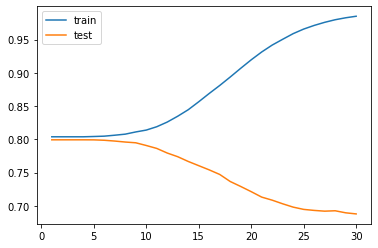

In [156]:
plt.plot(range(1, 31), score_list_train, label='train')
plt.plot(range(1, 31), score_list_test, label='test')
plt.legend()

In [157]:
model = KNeighborsClassifier()

In [158]:
scaler = MinMaxScaler()

In [162]:
scaler.fit(X_train)

MinMaxScaler()

In [163]:
scaler.transform(X_train)

array([[0.1125    , 0.1010101 , 0.03061224, ..., 0.        , 0.        ,
        1.        ],
       [0.1375    , 0.06060606, 0.02040816, ..., 0.        , 0.        ,
        0.        ],
       [0.0875    , 0.15151515, 0.01020408, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.3       , 0.16161616, 0.02040816, ..., 0.        , 0.        ,
        1.        ],
       [0.2625    , 0.3030303 , 0.01020408, ..., 0.        , 0.        ,
        1.        ],
       [0.325     , 0.08080808, 0.17346939, ..., 0.        , 0.        ,
        1.        ]])

In [164]:
scaler.transform(X_test)

array([[0.1125    , 0.23232323, 0.01020408, ..., 1.        , 0.        ,
        0.        ],
       [0.1375    , 0.1010101 , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.075     , 0.21212121, 0.01020408, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.125     , 0.04040404, 0.01020408, ..., 0.        , 0.        ,
        0.        ],
       [0.0625    , 0.01010101, 0.01020408, ..., 0.        , 0.        ,
        0.        ],
       [0.275     , 0.01010101, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [166]:
pipeline = Pipeline([('scaler', scaler), ('model', model)])

In [167]:
pred_proba = cross_val_predict(pipeline, X, y, cv=4, method='predict_proba')

In [170]:
df['pred_knn_proba'] = pred_proba[:, 1]

In [172]:
df['profit'] = df['target'].apply(lambda x: 
                                 15000 if x == 1 else -100000)

In [173]:
df['profit'].sum()

-385510000

<AxesSubplot:>

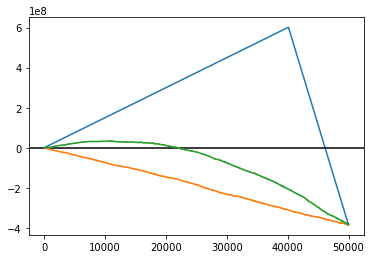

In [191]:
df.sort_values('target', ascending=False)['profit']\
.cumsum().reset_index(drop=True).plot()
plt.axhline(0, color='black')

df.sort_values('pred_baseline', ascending=False)['profit']\
.cumsum().reset_index(drop=True).plot()

df.sort_values('pred_lr_proba', ascending=False)['profit']\
.cumsum().reset_index(drop=True).plot()

In [194]:
df.sort_values('pred_lr_proba', ascending=False)['profit']\
.cumsum().max()

34500000

In [195]:
df.sort_values('target', ascending=False)['profit']\
.cumsum().max()

601890000